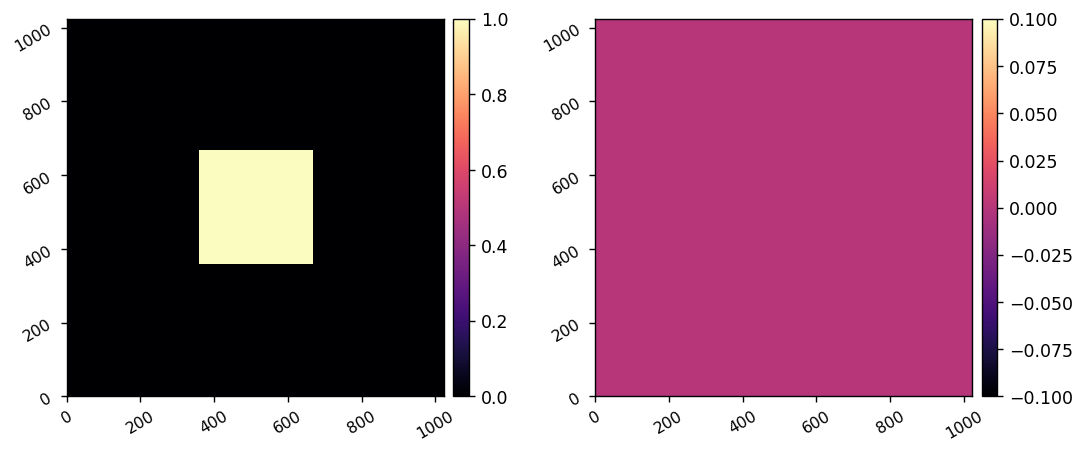

Propagating wavelength 575.000 nm.
PSF calculated in 1.840s


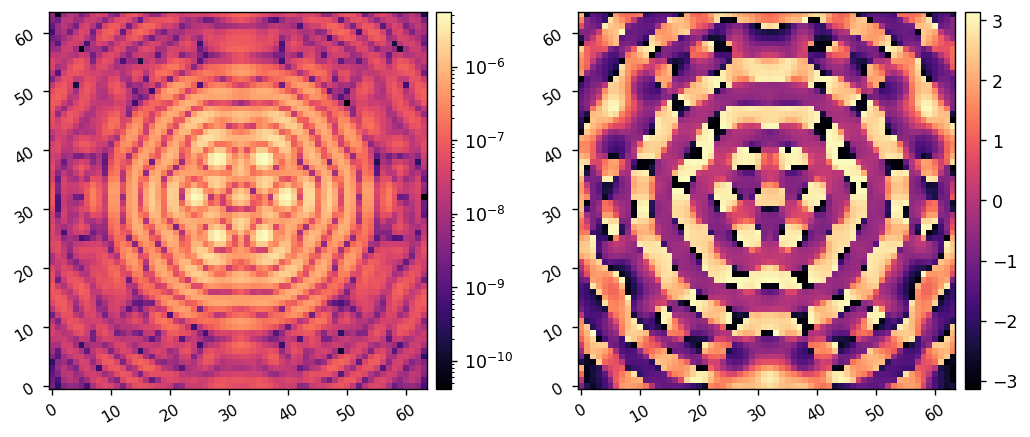

In [1]:
import numpy as np
import cupy as cp
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload

import poppy

from roman_cgi_iefc_2.poppy_roman_cgi_phasec import cgi
from roman_cgi_iefc_2 import iefc_utils as iefcu
from roman_cgi_iefc_2 import iefc_sim as iefc

import misc

data_dir = Path('/groups/douglase/kians-data-files/roman-cgi-iefc-data')
flatmaps_dir = Path.home()/'src/pyfalco/roman/flatmaps'

dm1_flatmap = fits.getdata(flatmaps_dir/'dm1_m_flat_hlc_band1.fits')
dm2_flatmap = fits.getdata(flatmaps_dir/'dm2_m_flat_hlc_band1.fits')
dm1_design = fits.getdata(flatmaps_dir/'dm1_m_design_hlc_band1.fits')
dm2_design = fits.getdata(flatmaps_dir/'dm2_m_design_hlc_band1.fits')

hlci = cgi.CGI_POPPY(polaxis=0, use_opds=False, use_fieldstop=False, quiet=False, ngpus=1/4)
misc.myimshow2(hlci.inwave.intensity.get(), hlci.inwave.phase.get())

ref_psf = hlci.calc_psf()[-1]
misc.myimshow2(ref_psf.intensity.get(), ref_psf.phase.get(), lognorm1=True)

npsf = hlci.npsf
Nact = hlci.Nact


In [9]:
rad_per_lamD = (hlci.wavelength_c/hlci.dm_diam.to(u.m))*u.radian
rad_per_lamD

<Quantity 1.24190065e-05 rad>

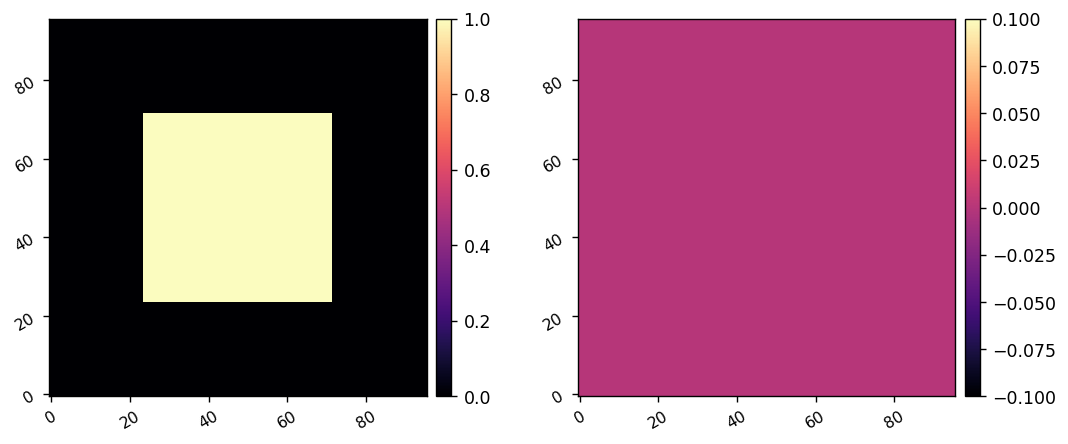

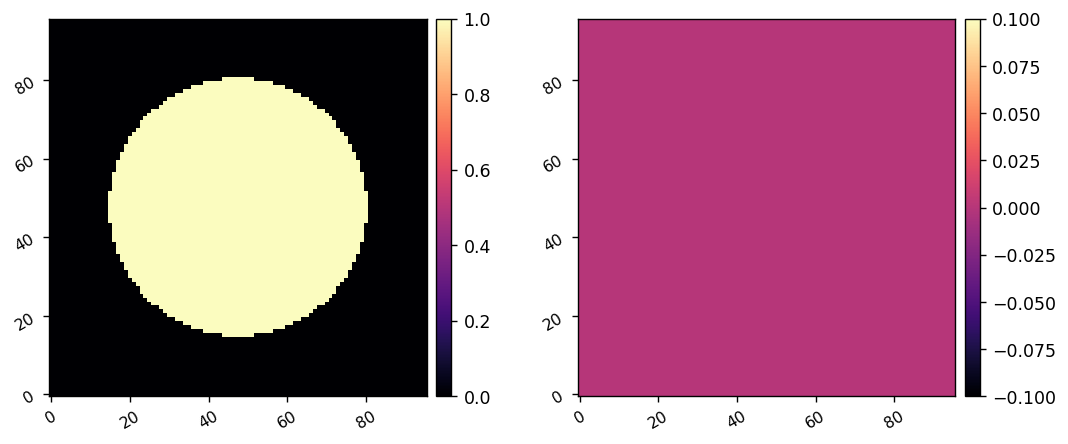

In [55]:
def fft2d(arr):
    return cp.fft.fftshift(cp.fft.fft2(cp.fft.ifftshift(arr)))
def ifft2d(arr):
    return cp.fft.ifftshift(cp.fft.ifft2(cp.fft.fftshift(arr)))

def create_probe(pupil, desired_focal, num_iterations=5):
    for i in range(num_iterations):
#         DM.set_surface(pupil)
#         new_pupil = DM.get_phasor(dm_wf)
        focal = fft2d(cp.angle(pupil))
        misc.myimshow2(cp.abs(focal), cp.abs(desired_focal))
        new_focal = focal + desired_focal
#         new_focal = desired_focal
        pupil = ifft2d(new_focal)
    return pupil

hlci = cgi.CGI_POPPY(polaxis=0, use_opds=False, use_fieldstop=False, quiet=False, ngpus=1/4)

poke_modes = hlci.wavelength_c.value/2 * iefcu.create_probe_poke_modes(Nact, 2*Nact//4, Nact//2, 2*Nact//4-1, Nact//2)
# hlci.set_dm1(poke_modes[1])

oversample = 2
N = round(hlci.Nact*oversample)
dm_wf = poppy.FresnelWavefront(beam_radius=hlci.dm_diam/2, npix=hlci.Nact, oversample=oversample)
misc.myimshow2(dm_wf.intensity, dm_wf.phase)

fp_pixelscale = (hlci.wavelength_c/hlci.dm_diam.to(u.m)/(hlci.oversample)).value / rad_per_lamD.value
xfp = np.linspace(-0.5, 0.5, N) * N * fp_pixelscale
xf,yf = np.meshgrid(xfp,xfp)

circ_params = { 'inner_radius':0, 'outer_radius':10, 'edge_position':0, 'direction':'' }
circ_focal = cp.array(iefcu.create_annular_focal_plane_mask(xf, yf, circ_params).astype(int))
rect_params = { 'x0':0, 'y0':0, 'w':10, 'h':20,}
rect_focal = cp.array(iefcu.create_box_focal_plane_mask(xf, yf, rect_params).astype(int))

desired_focal = circ_focal
# desired_focal = circ_focal*cp.exp(1j*cp.pi*circ_focal)

misc.myimshow2(cp.abs(desired_focal), cp.angle(desired_focal))

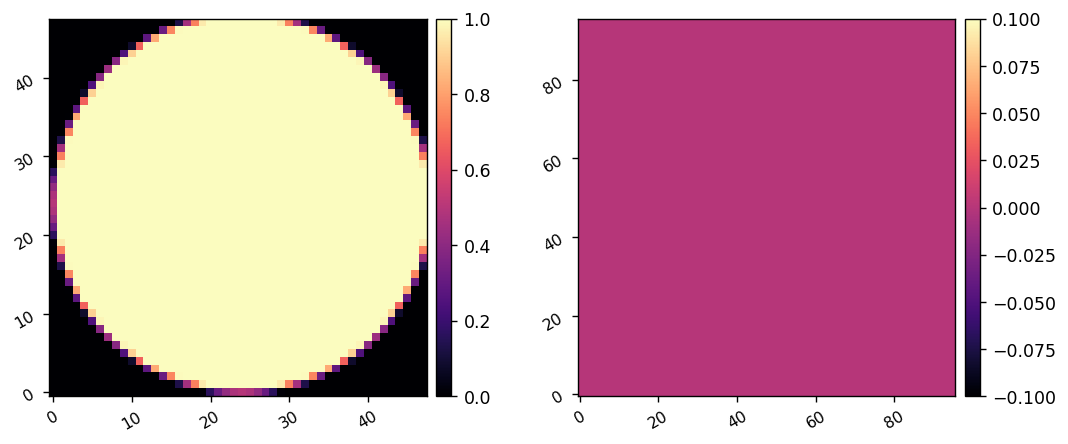

In [43]:
pupil = hlci.DM1.get_transmission(dm_wf)

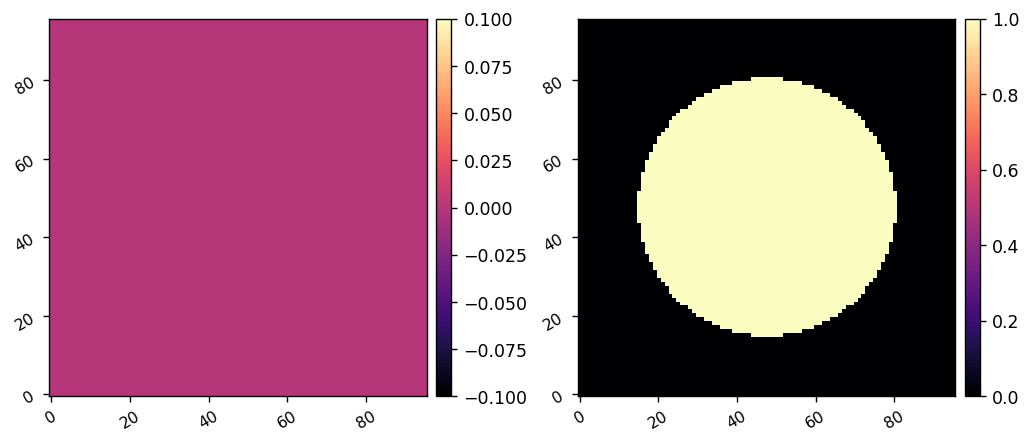

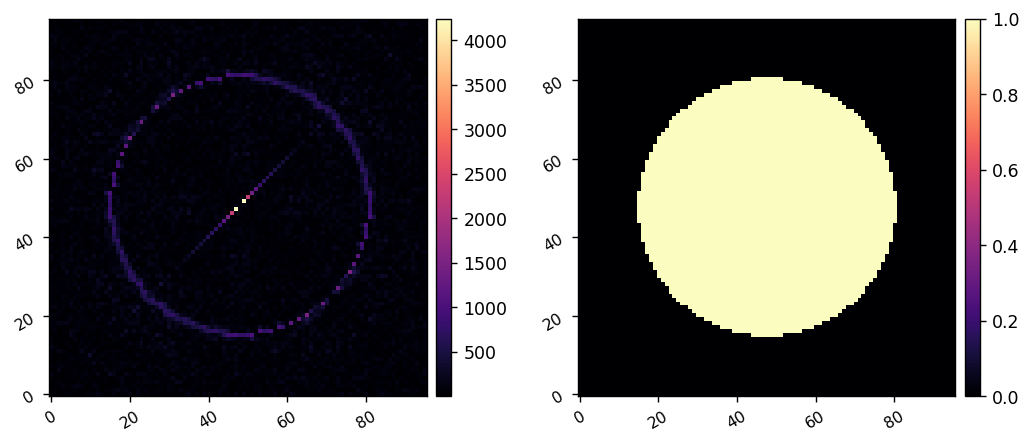

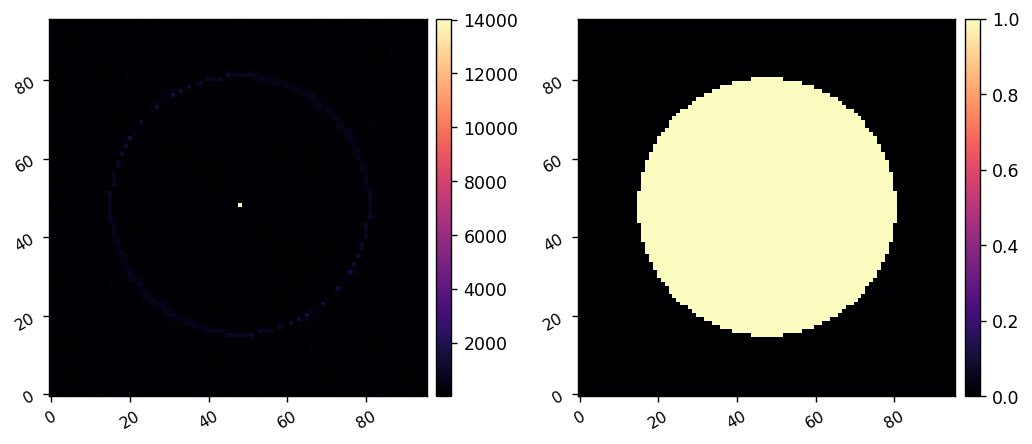

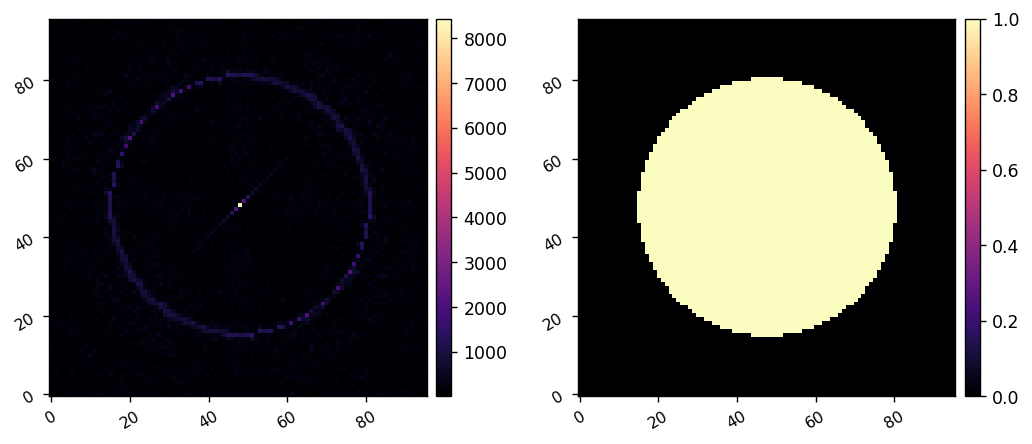

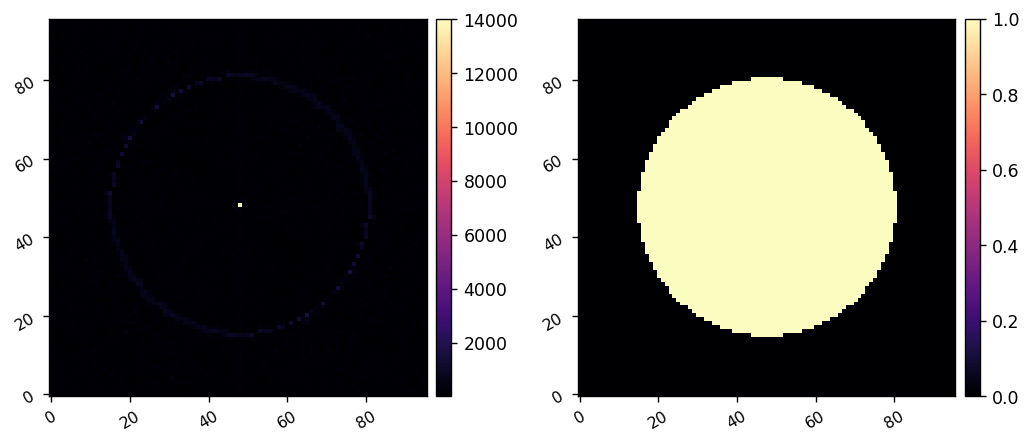

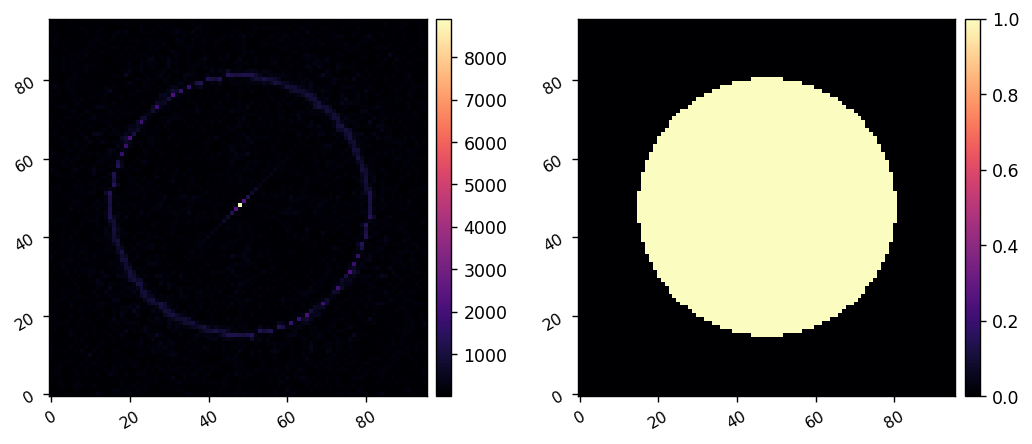

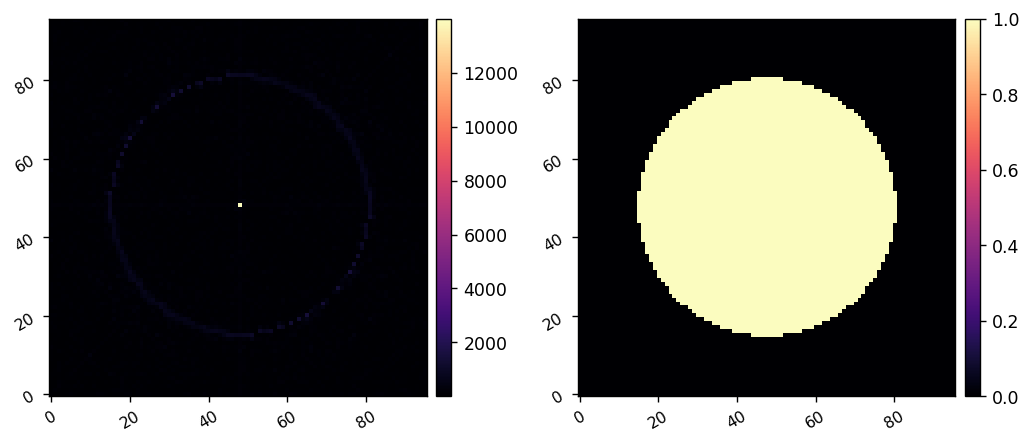

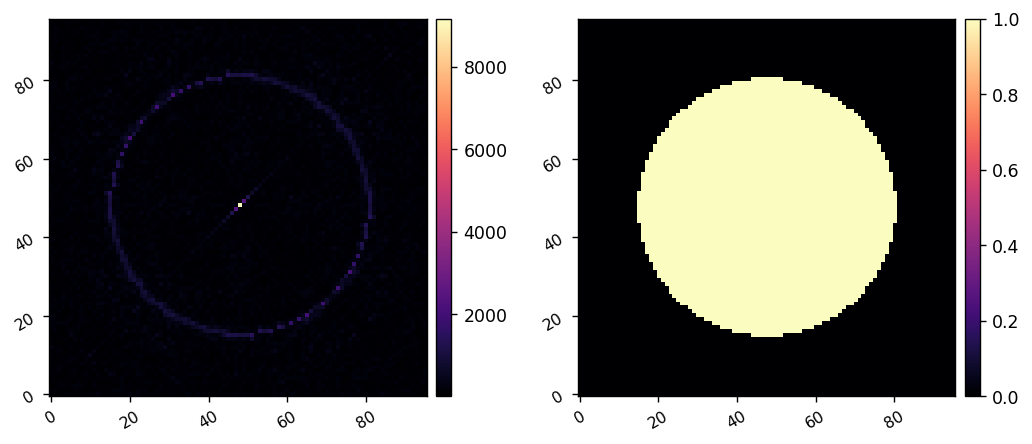

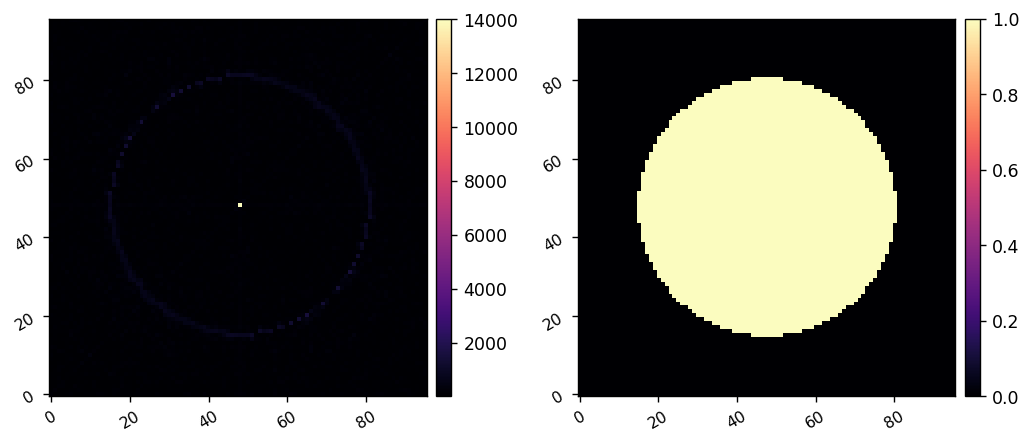

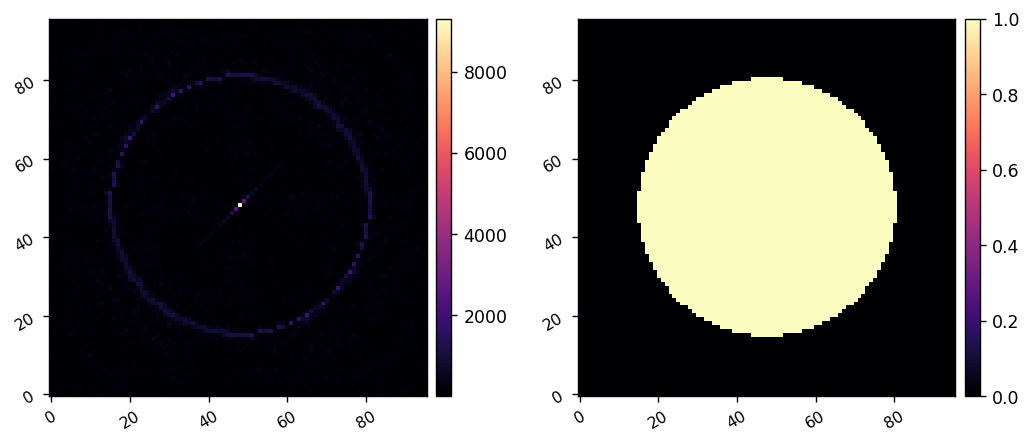

In [57]:
# probe_1 = create_probe(pupil, desired_focal, 1)
probe_2 = create_probe(pupil, desired_focal, 10)
# misc.myimshow2(probe_1.real, probe_1.imag, npix1=hlci.Nact, npix2=hlci.Nact)
# misc.myimshow2(probe_2.real, probe_2.imag, npix1=hlci.Nact, npix2=hlci.Nact)
# misc.myimshow2((probe_1-probe_2).real, probe.imag, npix1=hlci.Nact, npix2=hlci.Nact)

In [1]:
import proper

dm1 = dm1_flatmap
dm2 = dm2_flatmap

dm1_xc_act = 23.5           # for 48x48 DM, wavefront centered at actuator intersections: (0,0) = 1st actuator center
dm1_yc_act = 23.5 

dm1_xtilt_deg = 0           # tilt around X axis (deg)
dm1_ytilt_deg = 9.65        # effective DM tilt in deg including 9.65 deg actual tilt and pupil ellipticity
dm1_ztilt_deg = 0           # rotation of DM about optical axis (deg)

wf = proper.prop_begin( hlci.dm_diam.to(u.m).value, hlci.wavelength.to(u.m).value, hlci.Nact, 1)
dm1_map = proper.prop_dm(wf, dm1, dm1_xc_act, dm1_yc_act, hlci.act_spacing.to(u.m).value, 
                         XTILT=dm1_xtilt_deg, YTILT=dm1_ytilt_deg, ZTILT=dm1_ztilt_deg, FIT=False)
dm2_map = proper.prop_dm(wf, dm2, dm1_xc_act, dm1_yc_act, hlci.act_spacing.to(u.m).value, 
                         XTILT=dm1_xtilt_deg, YTILT=dm1_ytilt_deg, ZTILT=dm1_ztilt_deg, FIT=False)

misc.myimshow2(dm1, dm2)
misc.myimshow2(dm1_map, dm2_map)
misc.myimshow2(dm1-dm1_map, dm2-dm2_map)

# wavefront = proper.prop_begin( diam, lambda_m, n, float(pupil_diam_pix)/n )
# proper.prop_dm( wavefront, dm1, dm1_xc_act, dm1_yc_act, dm_sampling_m, 
#                XTILT=dm1_xtilt_deg, YTILT=dm1_ytilt_deg, ZTILT=dm1_ztilt_deg )

NameError: name 'dm1_flatmap' is not defined